In [3]:
from sympy import Eq, solve, pi
from sympy import lambdify
import numpy as np
from scipy.optimize import fsolve


from sympy import Matrix, cos, sin, symbols

def rotation_matrix_2d(theta):
    """Generate a 2D rotation matrix for a given angle."""
    return Matrix([
        [cos(theta), -sin(theta)],
        [sin(theta), cos(theta)]
    ])

def generate_constraint_equations_pr(theta_i, theta_j, r_x_i, r_y_i, r_x_j, r_y_j, u_x_i, u_y_i, u_x_j, u_y_j):
    """Generate the position restraint equations."""
    R_i = Matrix([r_x_i, r_y_i])
    R_j = Matrix([r_x_j, r_y_j])
    local_vector_i = Matrix([u_x_i, u_y_i])
    local_vector_j = Matrix([u_x_j, u_y_j])
    
    transformed_vector_i = rotation_matrix_2d(theta_i) * local_vector_i
    transformed_vector_j = rotation_matrix_2d(theta_j) * local_vector_j

    constraint_equations = R_i + transformed_vector_i - R_j - transformed_vector_j
    return constraint_equations

def generate_equations_wo_topology_pr(theta_i, theta_j, r_x_i, r_y_i, r_x_j, r_y_j):

    u_x_i, u_y_i, u_x_j, u_y_j = symbols('u_x_i u_y_i u_x_j u_y_j')


    # Generate the constraint equations
    equations = generate_constraint_equations_pr(theta_i, theta_j, r_x_i, r_y_i, r_x_j, r_y_j, u_x_i, u_y_i, u_x_j, u_y_j)    
    
    # Return the equation and the symbols
    #return (equations)
    return equations

def generate_equations_included_topology_pr(theta_i, theta_j, r_x_i, r_y_i, r_x_j, r_y_j, u_x_a, u_y_a, u_x_b, u_y_b):

    u_x_i, u_y_i, u_x_j, u_y_j = symbols('u_x_i u_y_i u_x_j u_y_j')


    # Generate the constraint equations
    equations = generate_constraint_equations_pr(theta_i, theta_j, r_x_i, r_y_i, r_x_j, r_y_j, u_x_i, u_y_i, u_x_j, u_y_j)
    
    # Substitute the symbolic variables with the provided values
    equations_substituted = equations.subs({u_x_i: u_x_a, u_y_i: u_y_a, u_x_j: u_x_b, u_y_j: u_y_b})
    
    
    # Return the equation and the symbols
    #return (equations)
    return equations_substituted


In [5]:
def four_bars_mechanism_example_symbolic_full():

    theta_1, theta_2, theta_3, theta_4 = symbols('theta_1 theta_2 theta_3 theta_4')
    r_x_1, r_y_1, r_x_2, r_y_2, r_x_3, r_y_3, r_x_4, r_y_4 = symbols('r_x_1 r_y_1 r_x_2 r_y_2 r_x_3 r_y_3 r_x_4 r_y_4')

    L2, L3, L4, Separation = symbols('L2 L3 L4 Separation')



    u_x_1_12 = 0
    u_y_1_12 = 0
    u_x_2_12 = 0
    u_y_2_12 = 0
    restrictions_pr12 = generate_equations_included_topology_pr(theta_1, theta_2, r_x_1, r_y_1, r_x_2, r_y_2, u_x_1_12, u_y_1_12, u_x_2_12, u_y_2_12)

    u_x_2_23 = L2
    u_y_2_23 = 0
    u_x_3_23 = 0
    u_y_3_23 = 0
    restrictions_pr23 = generate_equations_included_topology_pr(theta_2, theta_3, r_x_2, r_y_2, r_x_3, r_y_3, u_x_2_23, u_y_2_23, u_x_3_23, u_y_3_23)

    u_x_3_34 = L3
    u_y_3_34 = 0
    u_x_4_34 = 0
    u_y_4_34 = 0
    restrictions_pr34 = generate_equations_included_topology_pr(theta_3, theta_4, r_x_3, r_y_3, r_x_4, r_y_4, u_x_3_34, u_y_3_34, u_x_4_34, u_y_4_34)

    u_x_1_14 = Separation
    u_y_1_14 = 0
    u_x_4_14 = L4
    u_y_4_14 = 0
    restrictions_pr14 = generate_equations_included_topology_pr(theta_1, theta_4, r_x_1, r_y_1, r_x_4, r_y_4, u_x_1_14, u_y_1_14, u_x_4_14, u_y_4_14)

    # Stacking the matrices vertically to form a single large matrix
    restrictions_to_solve = restrictions_pr12.col_join(restrictions_pr23).col_join(restrictions_pr34).col_join(restrictions_pr14)

    # Substituting the known values into the equations
    restrictions_substituted = restrictions_to_solve.subs({
        r_x_1: 0,
        r_y_1: 0,
        theta_1: 0 })

    # Create a list of equations from the matrix
    equation_list = [Eq(restrictions_substituted[i, 0], 0) for i in range(restrictions_substituted.shape[0])]

    #print(equation_list) 

    return(equation_list)

In [6]:
four_bars_mechanism_example_symbolic_full()

[Eq(-r_x_2, 0),
 Eq(-r_y_2, 0),
 Eq(L2*cos(theta_2) + r_x_2 - r_x_3, 0),
 Eq(L2*sin(theta_2) + r_y_2 - r_y_3, 0),
 Eq(L3*cos(theta_3) + r_x_3 - r_x_4, 0),
 Eq(L3*sin(theta_3) + r_y_3 - r_y_4, 0),
 Eq(-L4*cos(theta_4) + Separation - r_x_4, 0),
 Eq(-L4*sin(theta_4) - r_y_4, 0)]

In [7]:
def four_bars_mechanism_example_symbolic(theta_2_value, L2, L3, L4, Separation):

    theta_1, theta_2, theta_3, theta_4 = symbols('theta_1 theta_2 theta_3 theta_4')
    r_x_1, r_y_1, r_x_2, r_y_2, r_x_3, r_y_3, r_x_4, r_y_4 = symbols('r_x_1 r_y_1 r_x_2 r_y_2 r_x_3 r_y_3 r_x_4 r_y_4')


    u_x_1_12 = 0
    u_y_1_12 = 0
    u_x_2_12 = 0
    u_y_2_12 = 0
    restrictions_pr12 = generate_equations_included_topology_pr(theta_1, theta_2, r_x_1, r_y_1, r_x_2, r_y_2, u_x_1_12, u_y_1_12, u_x_2_12, u_y_2_12)

    u_x_2_23 = L2
    u_y_2_23 = 0
    u_x_3_23 = 0
    u_y_3_23 = 0
    restrictions_pr23 = generate_equations_included_topology_pr(theta_2, theta_3, r_x_2, r_y_2, r_x_3, r_y_3, u_x_2_23, u_y_2_23, u_x_3_23, u_y_3_23)

    u_x_3_34 = L3
    u_y_3_34 = 0
    u_x_4_34 = 0
    u_y_4_34 = 0
    restrictions_pr34 = generate_equations_included_topology_pr(theta_3, theta_4, r_x_3, r_y_3, r_x_4, r_y_4, u_x_3_34, u_y_3_34, u_x_4_34, u_y_4_34)

    u_x_1_14 = Separation
    u_y_1_14 = 0
    u_x_4_14 = L4
    u_y_4_14 = 0
    restrictions_pr14 = generate_equations_included_topology_pr(theta_1, theta_4, r_x_1, r_y_1, r_x_4, r_y_4, u_x_1_14, u_y_1_14, u_x_4_14, u_y_4_14)

    # Stacking the matrices vertically to form a single large matrix
    restrictions_to_solve = restrictions_pr12.col_join(restrictions_pr23).col_join(restrictions_pr34).col_join(restrictions_pr14)

    # Substituting the known values into the equations
    restrictions_substituted = restrictions_to_solve.subs({
        r_x_1: 0,
        r_y_1: 0,
        theta_1: 0,
        theta_2: theta_2_value
    })

    # Create a list of equations from the matrix
    equation_list = [Eq(restrictions_substituted[i, 0], 0) for i in range(restrictions_substituted.shape[0])]

    #print(equation_list) 

    return(equation_list)

In [8]:
L2 = 2
L3 = 3
L4 = 5
Separation = 4


theta_2 = np.pi/2


four_bars_mechanism_example_symbolic(theta_2, L2, L3, L4, Separation)

[Eq(-r_x_2, 0),
 Eq(-r_y_2, 0),
 Eq(r_x_2 - r_x_3 + 1.22464679914735e-16, 0),
 Eq(r_y_2 - r_y_3 + 2.0, 0),
 Eq(r_x_3 - r_x_4 + 3*cos(theta_3), 0),
 Eq(r_y_3 - r_y_4 + 3*sin(theta_3), 0),
 Eq(-r_x_4 - 5*cos(theta_4) + 4, 0),
 Eq(-r_y_4 - 5*sin(theta_4), 0)]

In [9]:
import plotly.graph_objects as go



import plotly.graph_objects as go
import numpy as np

def plot_mechanism_updated(solution):
    # Extracting the coordinates from the solution
    r_x_2, r_y_2, r_x_3, r_y_3, r_x_4, r_y_4 = solution[0:6]
    
    # Create traces for each line
    trace1 = go.Scatter(x=[r_x_2, r_x_3], y=[r_y_2, r_y_3], mode='lines+markers', name='Link 2-3')
    trace2 = go.Scatter(x=[r_x_3, r_x_4], y=[r_y_3, r_y_4], mode='lines+markers', name='Link 3-4')
    trace3 = go.Scatter(x=[r_x_4, 5], y=[r_y_4, 0], mode='lines+markers', name='Link 4-Base')
    
    # Define layout with equal aspect ratio and specified axis ranges
    layout = go.Layout(title='Four Bars Mechanism Visualization',
                       xaxis=dict(title='X Coordinate', scaleanchor="y", scaleratio=1, range=[-15, 15]),
                       yaxis=dict(title='Y Coordinate', scaleanchor="x", scaleratio=1, range=[-15, 15]),
                       showlegend=True,
                       autosize=False,  # Disable automatic sizing to maintain aspect ratio
                       width=500,  # Set width of the plot
                       height=500)  # Set height of the plot
    
    # Create figure and plot
    fig = go.Figure(data=[trace1, trace2, trace3], layout=layout)
    fig.show()




# Testing the updated plotting function with the sample solution
#plot_mechanism_updated(solution)


In [18]:
import plotly.graph_objs as go

def plot_mechanism_updated_json(new_input, Separation):
    # Extract values from the input dictionary using string keys
    r_x_2_value = new_input['r_x_2']
    r_y_2_value = new_input['r_y_2']
    r_x_3_value = new_input['r_x_3']
    r_y_3_value = new_input['r_y_3']
    r_x_4_value = new_input['r_x_4']
    r_y_4_value = new_input['r_y_4']

    print(r_x_2_value)
    
    # Create traces for each line
    trace1 = go.Scatter(x=[r_x_2_value, r_x_3_value], y=[r_y_2_value, r_y_3_value], mode='lines+markers', name='Link 2-3')
    trace2 = go.Scatter(x=[r_x_3_value, r_x_4_value], y=[r_y_3_value, r_y_4_value], mode='lines+markers', name='Link 3-4')
    trace3 = go.Scatter(x=[r_x_4_value, Separation], y=[r_y_4_value, 0], mode='lines+markers', name='Link 4-Base')
    
    # Define layout with equal aspect ratio and specified axis ranges
    layout = go.Layout(title='Four Bars Mechanism Visualization',
                       xaxis=dict(title='X Coordinate', scaleanchor="y", scaleratio=1, range=[-15, 15]),
                       yaxis=dict(title='Y Coordinate', scaleanchor="x", scaleratio=1, range=[-15, 15]),
                       showlegend=True,
                       autosize=False,  # Disable automatic sizing to maintain aspect ratio
                       width=500,  # Set width of the plot
                       height=500)  # Set height of the plot
    
    # Create figure and plot
    fig = go.Figure(data=[trace1, trace2, trace3], layout=layout)
    fig.show()

# test_results2 = {
#     'r_x_2': 0.0,
#     'r_x_3': 1.22464679914735e-16,
#     'r_y_2': 0.0,
#     'r_y_3': 2.00000000000000,
#     'r_x_4': 3.06161699786838e-16,
#     'r_y_4': 5.00000000000000
# }

#plot_mechanism_updated_json(test_results2,Separation)
#plot_mechanism_updated_json(new_dict,Separation)


In [11]:
L2 = 2
L3 = 3
L4 = 5
Separation = 4


theta_2 = np.pi/2



#plot_mechanism_updated(solution)


[Eq(-r_x_2, 0),
 Eq(-r_y_2, 0),
 Eq(r_x_2 - r_x_3 + 1.22464679914735e-16, 0),
 Eq(r_y_2 - r_y_3 + 2.0, 0),
 Eq(r_x_3 - r_x_4 + 3*cos(theta_3), 0),
 Eq(r_y_3 - r_y_4 + 3*sin(theta_3), 0),
 Eq(-r_x_4 - 5*cos(theta_4) + 4, 0),
 Eq(-r_y_4 - 5*sin(theta_4), 0)]

In [13]:
import sympy as sp

# Solve the equations
solutions = sp.solve(four_bars_mechanism_example_symbolic(theta_2, L2, L3, L4, Separation)
)

solutions

[{r_x_2: 0.0,
  r_x_3: 1.22464679914735e-16,
  r_y_2: 0.0,
  r_y_3: 2.00000000000000,
  r_y_4: -0.853299832284320,
  r_x_4: -0.926649916142160,
  theta_3: 4.39837028074340,
  theta_4: 0.171499422654302},
 {r_x_2: 0.0,
  r_x_3: 1.22464679914735e-16,
  r_y_2: 0.0,
  r_y_3: 2.00000000000000,
  r_y_4: 4.45329983228432,
  r_x_4: 1.72664991614216,
  theta_3: 0.957519808434573,
  theta_4: -1.09879464065591}]

In [23]:

solutions_theta_3_1 = solutions[1]

solution_json = {str(key): value for key, value in solutions_theta_3_1.items()}

solution_json

{'r_x_2': 0.0,
 'r_x_3': 1.22464679914735e-16,
 'r_y_2': 0.0,
 'r_y_3': 2.00000000000000,
 'r_y_4': 4.45329983228432,
 'r_x_4': 1.72664991614216,
 'theta_3': 0.957519808434573,
 'theta_4': -1.09879464065591}

In [27]:
# plot_mechanism_updated_json({'r_x_2': 0.0,
#  'r_x_3': 1.22464679914735e-16,
#  'r_y_2': 0.0,
#  'r_y_3': 2.00000000000000,
#  'r_y_4': 4.45329983228432,
#  'r_x_4': 1.72664991614216,
#  'theta_3': 0.957519808434573,
#  'theta_4': -1.09879464065591},Separation)

def convert_floats(input_dict):
    return {k: float(v) if isinstance(v, sp.Float) else v for k, v in input_dict.items()}

solution_json_converted = convert_floats(solution_json)
plot_mechanism_updated_json(solution_json_converted, Separation)


#plot_mechanism_updated_json(solution_json,Separation)

0.0


## Specific mechanism Topology

In [24]:
# For this particular mechansim Topology
L2 = 2
L3 = 3
L4 = 5
Separation = 4

#And for this position of the 1 degree of freedom
theta_2 = np.pi/2


four_bars_mechanism_example_symbolic(theta_2, L2, L3, L4, Separation)

[Eq(-r_x_2, 0),
 Eq(-r_y_2, 0),
 Eq(r_x_2 - r_x_3 + 1.22464679914735e-16, 0),
 Eq(r_y_2 - r_y_3 + 2.0, 0),
 Eq(r_x_3 - r_x_4 + 3*cos(theta_3), 0),
 Eq(r_y_3 - r_y_4 + 3*sin(theta_3), 0),
 Eq(-r_x_4 - 5*cos(theta_4) + 4, 0),
 Eq(-r_y_4 - 5*sin(theta_4), 0)]

In [22]:
from sympy import symbols, Eq, cos, sin, diff, Matrix

# Define the symbols
theta_2, theta_3, theta_4 = symbols('theta_2 theta_3 theta_4')
r_x_2, r_y_2, r_x_3, r_y_3, r_x_4, r_y_4 = symbols('r_x_2 r_y_2 r_x_3 r_y_3 r_x_4 r_y_4')

# Define the function components
f = Matrix([
    -r_x_2,
    -r_y_2,
    r_x_2 - r_x_3,
    r_y_2 - r_y_3 + 2.0,
    r_x_3 - r_x_4 + 5*cos(theta_3),
    r_y_3 - r_y_4 + 5*sin(theta_3),
    -r_x_4 + 5 - 5*cos(theta_4),
    -r_y_4 -5*sin(theta_4),
    theta_2  # Additional equation (mov constraint)
])

# Variables with respect to which we differentiate
variables = [r_x_2, r_y_2, theta_2, r_x_3, r_y_3, theta_3, r_x_4, r_y_4, theta_4]

# Compute the Jacobian
jacobian_extended = f.jacobian(variables)
jacobian_extended


Matrix([
[-1,  0, 0,  0,  0,               0,  0,  0,               0],
[ 0, -1, 0,  0,  0,               0,  0,  0,               0],
[ 1,  0, 0, -1,  0,               0,  0,  0,               0],
[ 0,  1, 0,  0, -1,               0,  0,  0,               0],
[ 0,  0, 0,  1,  0, -5*sin(theta_3), -1,  0,               0],
[ 0,  0, 0,  0,  1,  5*cos(theta_3),  0, -1,               0],
[ 0,  0, 0,  0,  0,               0, -1,  0,  5*sin(theta_4)],
[ 0,  0, 0,  0,  0,               0,  0, -1, -5*cos(theta_4)],
[ 0,  0, 1,  0,  0,               0,  0,  0,               0]])

In [23]:
# Evaluate the determinant for the given values
theta_3_val = 0
theta_4_val = -np.pi / 2  # -90 degrees in radians

determinant_value = jacobian_extended.det().subs({theta_3: theta_3_val, theta_4: theta_4_val})
determinant_value


-25.0000000000000

<Figure size 720x720 with 0 Axes>

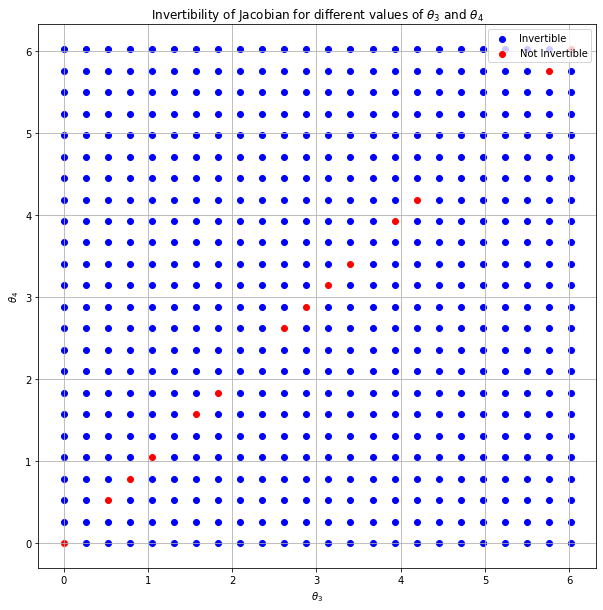

In [25]:
import numpy as np
import matplotlib.pyplot as plt

# Define the range for theta_3 and theta_4 in 15 degree steps
theta_values = np.arange(0, 2 * np.pi, np.deg2rad(15))

# Lists to store theta combinations for which the Jacobian is invertible or not
invertible_points = []
non_invertible_points = []

# Iterate over the theta values
for theta_3_val in theta_values:
    for theta_4_val in theta_values:
        # Substitute the values into the Jacobian matrix
        matrix_val = jacobian_extended.subs({theta_3: theta_3_val, theta_4: theta_4_val})
        
        # Check if the matrix is invertible by checking its determinant
        if matrix_val.det() != 0:
            invertible_points.append((theta_3_val, theta_4_val))
        else:
            non_invertible_points.append((theta_3_val, theta_4_val))

# Convert the lists to arrays for plotting
invertible_points = np.array(invertible_points)
non_invertible_points = np.array(non_invertible_points)

# Plot the points
plt.figure(figsize=(10, 10))
# plt.scatter(invertible_points[:, 0], invertible_points[:, 1], color='blue', label='Invertible')
# plt.scatter(non_invertible_points[:, 0], non_invertible_points[:, 1], color='red', label='Not Invertible')
# plt.xlabel('$\\theta_3$')
# plt.ylabel('$\\theta_4$')
# plt.title('Invertibility of Jacobian for different values of $\\theta_3$ and $\\theta_4$')
# plt.legend()
# plt.grid(True)
# plt.show()


# Plot the points with checks for empty arrays
plt.figure(figsize=(10, 10))

if invertible_points.size != 0:
    plt.scatter(invertible_points[:, 0], invertible_points[:, 1], color='blue', label='Invertible')

if non_invertible_points.size != 0:
    plt.scatter(non_invertible_points[:, 0], non_invertible_points[:, 1], color='red', label='Not Invertible')

plt.xlabel('$\\theta_3$')
plt.ylabel('$\\theta_4$')
plt.title('Invertibility of Jacobian for different values of $\\theta_3$ and $\\theta_4$')
plt.legend()
plt.grid(True)
plt.show()


In [26]:
import plotly.graph_objects as go
import numpy as np

# Assuming you have already computed the invertible_points and non_invertible_points

# Extracting x and y coordinates
x_invertible = [point[0] for point in invertible_points]
y_invertible = [point[1] for point in invertible_points]

x_non_invertible = [point[0] for point in non_invertible_points]
y_non_invertible = [point[1] for point in non_invertible_points]

# Create a scatter plot
fig = go.Figure()

# Add invertible points
fig.add_trace(go.Scatter(x=x_invertible, y=y_invertible, mode='markers', 
                         marker=dict(color='blue', size=10), name='Invertible'))

# Add non-invertible points
fig.add_trace(go.Scatter(x=x_non_invertible, y=y_non_invertible, mode='markers', 
                         marker=dict(color='red', size=10), name='Not Invertible'))

# Set plot title and axis labels
fig.update_layout(title='Invertibility of Jacobian for different values of θ3 and θ4',
                  xaxis_title='θ3', yaxis_title='θ4', 
                  xaxis=dict(tickvals=np.arange(0, 2*np.pi, np.pi/12), 
                             ticktext=['0', 'π/12', 'π/6', 'π/4', 'π/3', '5π/12', 'π/2', '7π/12', '2π/3', '3π/4', '5π/6', '11π/12', 'π', '13π/12', '7π/6', '5π/4', '4π/3', '17π/12', '3π/2', '19π/12', '5π/3', '7π/4', '11π/6', '23π/12', '2π']),
                  yaxis=dict(tickvals=np.arange(0, 2*np.pi, np.pi/12), 
                             ticktext=['0', 'π/12', 'π/6', 'π/4', 'π/3', '5π/12', 'π/2', '7π/12', '2π/3', '3π/4', '5π/6', '11π/12', 'π', '13π/12', '7π/6', '5π/4', '4π/3', '17π/12', '3π/2', '19π/12', '5π/3', '7π/4', '11π/6', '23π/12', '2π']),
                  showlegend=True)

# Display the plot
fig.show()


## 3D version (teta2,3,4)

In [28]:
# equations_substituted = equations.subs({u_x_i: u_x_a, u_y_i: u_y_a, u_x_j: u_x_b, u_y_j: u_y_b})

# # For this particular mechansim Topology
# L2 = 2
# L3 = 3
# L4 = 5
# Separation = 4

four_bars_mechanism_example_symbolic_full()

#four_bars_mechanism_example_symbolic_full().subs({L2: 2, L3: 3, L4:5, Separation:4})

[Eq(-r_x_2, 0),
 Eq(-r_y_2, 0),
 Eq(L2*cos(theta_2) + r_x_2 - r_x_3, 0),
 Eq(L2*sin(theta_2) + r_y_2 - r_y_3, 0),
 Eq(L3*cos(theta_3) + r_x_3 - r_x_4, 0),
 Eq(L3*sin(theta_3) + r_y_3 - r_y_4, 0),
 Eq(-L4*cos(theta_4) + Separation - r_x_4, 0),
 Eq(-L4*sin(theta_4) - r_y_4, 0)]

In [29]:
subs_dict = {L2: 2, L3: 3, L4:5, Separation:4}

eq_list_substituted_topology = [eq.subs(subs_dict) for eq in four_bars_mechanism_example_symbolic_full()]

eq_list_substituted_topology

[Eq(-r_x_2, 0),
 Eq(-r_y_2, 0),
 Eq(L2*cos(theta_2) + r_x_2 - r_x_3, 0),
 Eq(L2*sin(theta_2) + r_y_2 - r_y_3, 0),
 Eq(L3*cos(theta_3) + r_x_3 - r_x_4, 0),
 Eq(L3*sin(theta_3) + r_y_3 - r_y_4, 0),
 Eq(-L4*cos(theta_4) + Separation - r_x_4, 0),
 Eq(-L4*sin(theta_4) - r_y_4, 0)]

In [30]:
from sympy import Matrix, Eq

# Extract left-hand side of each equation
exprs = [eq.lhs for eq in eq_list_substituted_topology]

# Add the additional constraint
exprs.append(theta_2)

# Convert the list to a Matrix
f = Matrix(exprs)

print(f)


Matrix([[-r_x_2], [-r_y_2], [L2*cos(theta_2) + r_x_2 - r_x_3], [L2*sin(theta_2) + r_y_2 - r_y_3], [L3*cos(theta_3) + r_x_3 - r_x_4], [L3*sin(theta_3) + r_y_3 - r_y_4], [-L4*cos(theta_4) + Separation - r_x_4], [-L4*sin(theta_4) - r_y_4], [1.57079632679490]])


In [31]:
from sympy import symbols, Eq, cos, sin, diff, Matrix

# Define the symbols
theta_2, theta_3, theta_4 = symbols('theta_2 theta_3 theta_4')
r_x_2, r_y_2, r_x_3, r_y_3, r_x_4, r_y_4 = symbols('r_x_2 r_y_2 r_x_3 r_y_3 r_x_4 r_y_4')

# Define the function components
# f = Matrix([
#     -r_x_2,
#     -r_y_2,
#     r_x_2 - r_x_3,
#     r_y_2 - r_y_3 + 2.0,
#     r_x_3 - r_x_4 + 5*cos(theta_3),
#     r_y_3 - r_y_4 + 5*sin(theta_3),
#     -r_x_4 + 5 - 5*cos(theta_4),
#     -r_y_4 -5*sin(theta_4),
#     theta_2  # Additional equation (mov constraint)
# ])

# Variables with respect to which we differentiate
variables = [r_x_2, r_y_2, theta_2, r_x_3, r_y_3, theta_3, r_x_4, r_y_4, theta_4]

# Compute the Jacobian
jacobian_extended = f.jacobian(variables)
jacobian_extended


Matrix([
[-1,  0,                0,  0,  0,                0,  0,  0,                0],
[ 0, -1,                0,  0,  0,                0,  0,  0,                0],
[ 1,  0, -L2*sin(theta_2), -1,  0,                0,  0,  0,                0],
[ 0,  1,  L2*cos(theta_2),  0, -1,                0,  0,  0,                0],
[ 0,  0,                0,  1,  0, -L3*sin(theta_3), -1,  0,                0],
[ 0,  0,                0,  0,  1,  L3*cos(theta_3),  0, -1,                0],
[ 0,  0,                0,  0,  0,                0, -1,  0,  L4*sin(theta_4)],
[ 0,  0,                0,  0,  0,                0,  0, -1, -L4*cos(theta_4)],
[ 0,  0,                0,  0,  0,                0,  0,  0,                0]])

In [32]:
from sympy import symbols, Eq, cos, sin, diff, Matrix
from sympy import Matrix, Eq


def jacobian_topology(L2, L3, L4, Separation):

    four_bars_mechanism_example_symbolic_full()


    subs_dict = {L2: 2, L3: 3, L4:5, Separation:4}

        # Define the symbols
    theta_2, theta_3, theta_4 = symbols('theta_2 theta_3 theta_4')
    r_x_2, r_y_2, r_x_3, r_y_3, r_x_4, r_y_4 = symbols('r_x_2 r_y_2 r_x_3 r_y_3 r_x_4 r_y_4')

    eq_list_substituted_topology = [eq.subs(subs_dict) for eq in four_bars_mechanism_example_symbolic_full()]

    eq_list_substituted_topology


    # Extract left-hand side of each equation
    exprs = [eq.lhs for eq in eq_list_substituted_topology]

    # Add the additional constraint
    exprs.append(theta_2)

    # Convert the list to a Matrix
    f = Matrix(exprs)








    # Variables with respect to which we differentiate
    variables = [r_x_2, r_y_2, theta_2, r_x_3, r_y_3, theta_3, r_x_4, r_y_4, theta_4]

    # Compute the Jacobian
    jacobian_extended = f.jacobian(variables)
    return(jacobian_extended)



In [33]:
jacobian_topology(2,3,5,4)

Matrix([
[-1,  0,                0,  0,  0,                0,  0,  0,                0],
[ 0, -1,                0,  0,  0,                0,  0,  0,                0],
[ 1,  0, -L2*sin(theta_2), -1,  0,                0,  0,  0,                0],
[ 0,  1,  L2*cos(theta_2),  0, -1,                0,  0,  0,                0],
[ 0,  0,                0,  1,  0, -L3*sin(theta_3), -1,  0,                0],
[ 0,  0,                0,  0,  1,  L3*cos(theta_3),  0, -1,                0],
[ 0,  0,                0,  0,  0,                0, -1,  0,  L4*sin(theta_4)],
[ 0,  0,                0,  0,  0,                0,  0, -1, -L4*cos(theta_4)],
[ 0,  0,                1,  0,  0,                0,  0,  0,                0]])

In [34]:
theta_values = np.arange(0, 2 * np.pi, np.deg2rad(15))


# Redefine the Jacobian matrix and simplify it in-place
#jacobian_extended.simplify()

# Resetting the lists for storing theta combinations
invertible_points_3d = []
non_invertible_points_3d = []

# Clearing the set of computed matrices
#computed_matrices.clear()

# Iterate over the theta values
for theta_2_val in theta_values:
    for theta_3_val in theta_values:
        for theta_4_val in theta_values:
            # Substitute the values into the Jacobian matrix
            matrix_val = jacobian_extended.subs({theta_2: theta_2_val, theta_3: theta_3_val, theta_4: theta_4_val})
            matrix_str = str(matrix_val)  # Convert the matrix to string for hashing
            if matrix_str not in computed_matrices:
                computed_matrices.add(matrix_str)
                if matrix_val.det() != 0:
                    invertible_points_3d.append((theta_2_val, theta_3_val, theta_4_val))
                else:
                    non_invertible_points_3d.append((theta_2_val, theta_3_val, theta_4_val))

invertible_points_3d = np.array(invertible_points_3d)
non_invertible_points_3d = np.array(non_invertible_points_3d)

invertible_points_3d.shape, non_invertible_points_3d.shape


NameError: name 'computed_matrices' is not defined

In [54]:
# Define the range for theta_2, theta_3, and theta_4 in 15 degree steps
theta_values = np.arange(0, 2 * np.pi, np.deg2rad(15))

theta_values2 = np.arange(0, np.pi/2, np.deg2rad(15))

# Lists to store the results for visualization
theta_combinations = []
colors = []

# Iterate over the theta values
for theta_2_val in theta_values:
    print(theta_2_val)
    for theta_3_val in theta_values:
        for theta_4_val in theta_values:
            # Get the Jacobian matrix for the current combination of theta values
            jacobian_matrix = jacobian_topology(2, 3, 5, 4).subs({theta_2: theta_2_val, theta_3: theta_3_val, theta_4: theta_4_val})
            
            # Check if the matrix is invertible by computing its determinant
            color = 'green' if jacobian_matrix.det() != 0 else 'red'
            
            # Store the results for visualization
            theta_combinations.append((theta_2_val, theta_3_val, theta_4_val))
            colors.append(color)

len(theta_combinations), len(colors)

0.0
0.2617993877991494
0.5235987755982988
0.7853981633974483
1.0471975511965976
1.308996938995747


(216, 216)

In [35]:
import plotly.graph_objects as go
import numpy as np

def create_3d_scatter(theta_points, colors):
    """Create a 3D scatter plot using Plotly."""
    fig = go.Figure(data=[go.Scatter3d(
        x=[point[0] for point in theta_points],
        y=[point[1] for point in theta_points],
        z=[point[2] for point in theta_points],
        mode='markers',
        marker=dict(
            size=6,
            color=colors,                # set color to an array/list of desired values
            opacity=0.8
        )
    )])

    fig.update_layout(scene=dict(
            xaxis_title='Theta 2',
            yaxis_title='Theta 3',
            zaxis_title='Theta 4'
        ),
        width=700,
        margin=dict(r=20, b=10, l=10, t=10))
    fig.show()

# Example
#theta_values = np.arange(0, 2*np.pi, np.deg2rad(15))

theta_values = np.arange(0, 2 * np.pi, np.deg2rad(15))
theta_values2 = np.arange(0, np.pi/2, np.deg2rad(15))


theta_combinations = []
colors = []

for theta_2_val in theta_values2:
    print(theta_values2)
    for theta_3_val in theta_values:
        for theta_4_val in theta_values:
            jacobian_matrix = jacobian_topology(2, 3, 5, 4).subs({theta_2: theta_2_val, theta_3: theta_3_val, theta_4: theta_4_val})
            color = 'green' if jacobian_matrix.det() != 0 else 'red'
            theta_combinations.append((theta_2_val, theta_3_val, theta_4_val))
            colors.append(color)

create_3d_scatter(theta_combinations, colors)


[0.         0.26179939 0.52359878 0.78539816 1.04719755 1.30899694]


KeyboardInterrupt: 